In [1]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from numba import njit
pd.set_option('display.max_rows', 10)

%load_ext autoreload
%autoreload 2

# Potential impact of post-exposure prophalaxis for COVID-19 with monoclonal antibodies

Updated from March 2021 analysis to include more recent confirmed cases, and also vaccination coverage.

Also updated to use completed, and now peer-reviewed, results from RCT

And in this version, use the KFF survey results that 77% of unvaccinated adults say everyone in their household is unvaccinated. https://www.kff.org/coronavirus-covid-19/poll-finding/kff-covid-19-vaccine-monitor-june-2021/

In [2]:
# range of values to consider in alternative scenarios
coverage_levels = [0, 1/4, 1/2, 3/4, 1]
age_lower_bounds = [0, 20, 40, 50, 60, 70, 80]

In [3]:
n_draws = 100 # number of bootstrap resamples for quantifying uncertainty
np.random.seed(12345)  # set random seed for reproducibility

In [4]:
rct_attack_rate_without_mAbs = np.random.binomial(752, 59/752, size=n_draws) / 752 
rct_attack_rate_with_mAbs = np.random.binomial(753, 11/753, size=n_draws) / 753 

pooled_sar = 0.211 
rct_ve = 1 - (rct_attack_rate_with_mAbs / rct_attack_rate_without_mAbs) 

se = (24.8-17.4)/(1.96*2)/100
#var = p*(1-p)/N => N = (0.211 * (1-0.211))/se^2
n_size = round((0.211 * (1-0.211))/se**2)

attack_rate_without_mAbs = np.random.binomial(n_size, pooled_sar, size=n_draws) / n_size 
attack_rate_with_mAbs = np.random.binomial(n_size, pooled_sar) * (1 - rct_ve) / n_size 

np.random.seed(12345) # set random seed for reproducibility 
mAbs_unit_cost = np.random.normal(2_550, 125, size=n_draws) # New cost; 
COVID_hospitalization_unit_cost = np.random.normal(73_300, 7_330, size=n_draws) 

In [5]:
mAbs_unit_cost

array([2524.41154256, 2609.86791726, 2485.07016062, 2480.53371196,
       2795.72257156, 2724.17572912, 2561.61348459, 2585.2182691 ,
       2646.12782095, 2705.80434205, 2675.8986697 , 2387.97236136,
       2584.37395418, 2578.61410987, 2719.1146044 , 2660.80366757,
       2299.79533629, 2503.51968286, 2758.62816369, 2495.17878302,
       2482.53231931, 2609.6231263 , 2956.11798993, 2422.34655946,
       2477.86408712, 2565.51515946, 2587.82669524, 2615.47150852,
       2550.11753472, 2717.9762242 , 2460.80700186, 2446.10580764,
       2253.72104326, 2317.40490143, 2442.4053252 , 2620.01816163,
       2391.75818854, 2564.97839058, 2417.06094399, 2591.61033945,
       2255.07264908, 2525.05713058, 2357.25055902, 2428.65801097,
       2386.62121863, 2585.79371838, 2597.24801387, 2455.76418315,
       2591.41070627, 2718.71777681, 2558.7345861 , 2580.83426375,
       2548.51729987, 2675.60144885, 2715.89932672, 2435.09230528,
       2356.36169521, 2552.77307483, 2644.79539313, 2467.43445

In [6]:
%%time

# Administrated data on how many vaccines have been given in the US
url = "https://data.cdc.gov/api/views/rh2h-3yt2/rows.csv?accessType=DOWNLOAD"
vax_dt = pd.read_csv(url)
#vax_dt

Wall time: 3.19 s


In [7]:
total_vax = vax_dt[(vax_dt["Date"] == "05/31/2021") & (vax_dt["date_type"] == "Report") & (vax_dt["Location"] == "US")]
us_pop = 332_378_911 #census population on 5/31/2021 (https://www.census.gov/popclock/)

p_vax   = np.random.binomial(us_pop, total_vax.Admin_Dose_1_Cumulative/us_pop, size=n_draws) / us_pop
p_unvax = 1-p_vax
#p_vax, p_unvax

In [8]:
# TODO: fill in the following with an appropriate RCT (or meta-analysis, or real-world effectiveness study...)
# numbers from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8022879/pdf/mm7013e3.pdf
n_treated = 2_928 #(excluded 33 cases in study because occured before 14 days period)
cases_treated = 11

n_control = 989
cases_control = 161

efficacy = 1 - (
    (np.random.binomial(n_treated, cases_treated/n_treated, size=n_draws) / n_treated)
    /
    (np.random.binomial(n_control, cases_control/n_control, size=n_draws) / n_control))

## equ1: p_cc = (p_cc_vax*p_vax) + (p_cc_unvax*p_unvax)
## equ2: p_unvax_cc = (p_cc_unvax * p_unvax)/p_cc
## equ3: p_cc_vax = efficacy * p_cc_unvax

## substitute equ3 into equ1: p_cc = ((efficacy * p_cc_unvax) * p_vax) + (p_cc_unvax*p_unvax)
## p_cc = p_cc_unvax((efficacy * p_vax) + p_unvax)

## substitute equ1 into equ2: p_unvax_cc = (p_cc_unvax * p_unvax) / p_cc_unvax((efficacy * p_vax) + p_unvax)
p_unvax_cc =  p_unvax / (((1-efficacy) * (p_vax)) + p_unvax)
#p_unvax_cc

In [9]:
pr_unvaccinated_cond_on_test_positive = p_unvax_cc  # np.random.binomial(10_000, unvac_covPos, size=n_draws)/10_000 

# https://files.kff.org/attachment/Topline-KFF-COVID-19-Vaccine-Monitor-June-2021.pdf
# n = 458, p_all_hh_members unvaccinated = 0.69
pr_case_in_unvaccinated_household = pr_unvaccinated_cond_on_test_positive * np.random.binomial(458, 0.69, size=n_draws) / 458

In [10]:
%%time

df_cdc = pd.read_csv('data/cdc_covid_linelist_may_2021.csv.bz2', low_memory=False)

Wall time: 367 ms


# 1.	Estimate the number of COVID-19 case count, n_1, and the age-/sex-/race-stratified case counts

    n_1 (a,s,r)=# cases for strata (a,s,r).


In [11]:
# first select all cases during time period of interest
diagnosis_date = pd.to_datetime(df_cdc.pos_spec_dt)
rows = (diagnosis_date >= '2021-05-01') & (diagnosis_date < '2021-06-01')
t = df_cdc[rows].copy()  # NOTE: same dataframe, code just kept for convenience

In [12]:
n_1_total = len(t) #total cases
print(f'Total cases: {n_1_total:,}')

Total cases: 154,136


In [13]:
age_cutpoints = [0,10,20,30,40,50,60,70,80,125]
cdc_age_map = {f'{a} - {a+9} Years':a for a in age_cutpoints}
cdc_age_map['80+ Years'] = 80
t['age'] = t.age_group.map(cdc_age_map)

t['age_group'] = pd.cut(t.age, age_cutpoints, right=False)
t['sex'] = t.sex.map({'Male': 'male', 'Female':'female'})
t['race_eth'] = t.race_ethnicity_combined.map({
    'White, Non-Hispanic':'White',
    'Black, Non-Hispanic':'Black',
    'Hispanic/Latino':'Hispanic', 
    'American Indian/Alaska Native, Non-Hispanic':'Other',
    'Multiple/Other, Non-Hispanic':'Other',
    'Asian, Non-Hispanic':'Other',
    'Native Hawaiian/Other Pacific Islander, Non-Hispanic':'Other',
})

t['weight'] = 1.0
#t

In [14]:
df_cdc_month = t
#df_cdc_month.shape

In [15]:
# stratification factors
age_groups = pd.cut(np.random.uniform(0, 125, 10_000), age_cutpoints, right=False).unique().sort_values()
#age_groups = pd.cut(list(range(0, 125)), age_cutpoints, right=False).unique()
sexes = ['male', 'female']
race_eth = ['White', 'Black', 'Hispanic', 'Other']
stratification_groups = pd.MultiIndex.from_product([age_groups, sexes, race_eth])

In [16]:
%%time
#    n_1 (a,s,r) = number of cases for strata (a,s,r).

n_1 = {}

for k in range(n_draws):
    # use bootstrap to resample confirmed cases, to quantify uncertainty
    resampled_rows = np.random.choice(df_cdc_month.index, size=len(t), replace=True)
    df_selected_cdc = df_cdc_month.loc[resampled_rows]
    
    n_1[k] = df_selected_cdc.groupby(['age_group', 'sex', 'race_eth']).weight.sum()
    
    # use parametric resampling from a possion distribution to also include uncertainty in total number of cases
    n_1[k] = np.random.poisson(n_1_total) * n_1[k] / n_1[k].sum()

Wall time: 4.11 s


In [17]:
# TODO: Table 1 showing the demographics of the confirmed case population,
# highlighting amount of missingness and also including household size distribution

In [18]:
n_1_mean = pd.DataFrame(n_1).T.mean()
np.round(n_1_mean.unstack().unstack(),1)  # number of confirmed cases of COVID-19, stratified by age, sex, and race/ethnicity

race_eth    Black         Hispanic           Other           White        
sex        female    male   female    male  female    male  female    male
age_group                                                                 
[0, 10)    1237.8  1330.2   1215.5  1328.5   762.0   858.7  2815.6  2915.2
[10, 20)   2193.7  2008.9   2371.1  2220.4  1256.9  1235.6  7289.0  6700.6
[20, 30)   3497.5  2315.0   2582.2  2395.0  1712.9  1333.9  8136.5  6820.4
[30, 40)   3354.1  2159.9   2445.7  2147.0  1423.2  1189.1  7721.4  5988.9
[40, 50)   2206.6  1563.5   1715.3  1587.1   983.3   808.4  6747.7  5854.6
[50, 60)   1744.8  1205.3   1159.5   950.6   677.8   662.6  6171.3  5938.7
[60, 70)   1028.5   696.5    637.3   469.0   437.3   432.4  4387.4  4030.7
[70, 80)    431.9   215.1    266.5   180.2   174.0   143.0  2321.7  2178.1
[80, 125)   249.5    98.6    144.0    64.1   109.6    85.5  1412.1   972.3

In [19]:
# assert np.allclose(n_1_mean.sum(), n_1_total)


## 2. Estimate the stratified number of household contacts who might benefit from mAbs PEP 

Think of entry $(i,j)$ in this table as the number of people in group $j$ you would find who have been exposed to COVID, if you did a household visit for a COVID-19 case in group $i$.

### TODO: Figure out how to quantify uncertainty for this in a reasonable amount of time.

In [20]:
acs = pd.read_csv('data/acs_2019_pums.csv.bz2')
#acs.head()

In [21]:
acs['age_group'] = pd.cut(acs.age, age_cutpoints, right=False)
acs['sex'] = acs.sex.map({1:'male', 2:'female'})
acs['race_eth'] = acs.race_eth.map({1:'White',
                                    2:'Black',
                                    3:'Hispanic', 
                                    4:'Other'})
#acs.head()

In [22]:
g_acs = acs[acs.household_id.str.contains('HU')].groupby(['age_group', 'sex', 'race_eth'])
#g_acs.head()

In [23]:
%%time
n_hh = {}

for k in range(n_draws):
    print('\n',k)
    n_hh[k] = pd.DataFrame(0, index=stratification_groups, columns=stratification_groups)
    n_hh[k] = n_hh[k].sort_index()  # make a pesky warning go away, and possibly make things faster --- see https://stackoverflow.com/questions/54307300/what-causes-indexing-past-lexsort-depth-warning-in-pandas
    
    for i in stratification_groups:
        print('.', flush=True, end=' ')
        hh_ids = g_acs.get_group(i).household_id  # ids for households containing a person from stratification group i
        hh_ids_k = np.random.choice(hh_ids, size=100, replace=True)  # randomly resampled hhs with person from group i

        for j in stratification_groups:
            t = g_acs.get_group(j) # all people in stratification from j

            df_ij = t[t.household_id.isin(hh_ids_k)]  # people in stratification group j who live in household with person from stratification group i

            hh_ij = pd.Series(0, index=hh_ids_k).add(
                        df_ij.household_id.value_counts() * pd.Series(hh_ids_k).value_counts(),  # resampling with replacement means some hhs will appear more than once
                        fill_value=0
                    )

            n_hh[k].loc[i,j] = hh_ij.mean()
            if i == j:
                n_hh[k].loc[i,j] -= 1 # don't include the person with a confirmed case when tallying household exposure count


 0
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 1
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 2
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 3
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 4
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 5
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 6
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [24]:
%%time

n_2_unvax = {}
n_2_unvax_total = {}

n_2_all = {}
n_2_all_total = {}

for k in range(n_draws):
    n_2_unvax[k] = pd.Series(0.0, index=stratification_groups)
    n_2_all[k] = pd.Series(0.0, index=stratification_groups)
    for j in stratification_groups:
        a0,a1 = j[0].left, j[0].right
        s,r=j[1],j[2]
        j_cov = (f'[{a0}, {a1})', s, r)
        for i in stratification_groups:
            n_2_unvax[k][j] += n_1[k][i] * pr_case_in_unvaccinated_household[k] * n_hh[k].loc[i,j] # count only the unvaccinated who's household is all unvaccinated, which is a lower-bound on total
            n_2_all[k][j] += n_1[k][i] * n_hh[k].loc[i,j]
    n_2_unvax_total[k] = n_2_unvax[k].sum()
    n_2_all_total[k] = n_2_all[k].sum()
n_2_unvax_mean = sum(n_2_unvax.values()) / n_draws
n_2_all_mean = sum(n_2_all.values()) / n_draws
np.round(n_2_all_mean.unstack().unstack(), 1)

Wall time: 9min 58s


Black         Hispanic           Other            White         
           female    male   female    male  female    male   female     male
[0, 10)    6329.1  6601.2   7491.1  7797.7  4225.3  4330.5  16771.6  17984.6
[10, 20)   6552.4  6894.3   8131.1  8355.5  3774.6  3949.9  18287.1  19499.7
[20, 30)   4246.4  3793.3   5452.2  5492.5  2651.0  2704.0  11125.5  11777.0
[30, 40)   4452.3  3353.0   5315.4  4921.4  2865.9  2430.3  13835.4  13192.2
[40, 50)   4277.7  3352.4   5071.6  4545.0  2902.9  2450.2  15137.1  14973.8
[50, 60)   3811.8  3030.2   3339.4  3373.0  2112.4  1973.6  12054.1  12509.9
[60, 70)   2617.8  2002.8   1784.5  1642.4  1407.0  1245.9   7040.0   7535.1
[70, 80)   1186.8   842.4    784.3   667.3   650.2   537.0   3535.2   3524.6
[80, 125)   560.7   268.9    390.7   247.6   309.8   217.3   1590.3   1269.9

In [25]:
np.round(n_2_unvax_mean.unstack().unstack(), 1)

Black         Hispanic           Other            White         
           female    male   female    male  female    male   female     male
[0, 10)    4262.0  4446.7   5043.7  5250.5  2846.0  2915.8  11295.2  12105.1
[10, 20)   4414.3  4644.8   5478.7  5628.0  2542.2  2659.4  12314.4  13132.3
[20, 30)   2859.0  2553.6   3671.3  3700.2  1785.6  1820.8   7490.6   7936.4
[30, 40)   2999.9  2258.1   3579.6  3314.7  1930.3  1636.5   9317.6   8883.3
[40, 50)   2879.6  2257.3   3416.3  3060.7  1954.4  1650.5  10194.2  10084.3
[50, 60)   2566.7  2040.7   2248.8  2271.6  1422.4  1328.8   8120.0   8428.6
[60, 70)   1762.7  1348.1   1201.6  1106.1   947.2   838.8   4740.2   5074.7
[70, 80)    799.0   567.6    528.2   449.8   437.6   361.8   2381.4   2375.1
[80, 125)   377.4   181.1    263.0   167.0   208.7   146.3   1072.1    855.0

In [26]:
n_2_all_total_mean = sum(n_2_all_total.values()) / n_draws
n_2_all_total_lb = np.percentile(list(n_2_all_total.values()), 2.5)
n_2_all_total_ub = np.percentile(list(n_2_all_total.values()), 97.5)

In [27]:
print(f'total number of (vaccinated & unvaccinated) household contacts: {n_2_all_total_mean:,.1f} (95% UI {n_2_all_total_lb:,.1f}-{n_2_all_total_ub:,.1f})')

total number of (vaccinated & unvaccinated) household contacts: 381,357.0 (95% UI 374,041.3-389,816.6)


In [28]:
n_2_total_mean = sum(n_2_unvax_total.values()) / n_draws
n_2_total_lb = np.percentile(list(n_2_unvax_total.values()), 2.5)
n_2_total_ub = np.percentile(list(n_2_unvax_total.values()), 97.5)

In [29]:
print(f'total number of unvaccinated household contacts: {n_2_total_mean:,.1f} (95% UI {n_2_total_lb:,.1f}-{n_2_total_ub:,.1f})')

total number of unvaccinated household contacts: 256,831.7 (95% UI 240,276.2-272,738.8)


In [30]:
# household exposure rate (exposures per 100,000 person-months) by race
n_2_race = {}
for k in range(n_draws):
    n_2_race[k] = 100_000 * (n_2_unvax[k].unstack().sum() / g_acs.weight.sum().unstack().sum())

np.round(sum(n_2_race.values())/n_draws, 1)

Black       111.1
Hispanic     84.9
Other        92.6
White        70.6
dtype: float64

## 3. Estimate the number of people who receive PEP in scenarios with a range of coverage levels c and minimum age a_0 for receiving PEP

In [31]:
n_PEP = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        n_PEP[c,a0] = {}
        for k in range(n_draws):
            age_mask = pd.Series([a.left >= a0 for a,s,r in stratification_groups],
                         index=stratification_groups)
            n_PEP[c,a0][k] = c*n_2_unvax[k]*age_mask


In [32]:
# treatment rate (tx per 100,000 person-months) by race
c,a = .50,50
n_PEP_mean = sum(n_PEP[c, a].values())/n_draws
np.round(100_000 * (n_PEP_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 1) 

Black       12.4
Hispanic     6.9
Other        9.6
White        8.6
dtype: float64

## 4.	Estimate the number of people who develop a symptomatic COVID-19 infection in each scenario

In [33]:
n_COVID = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        n_COVID[c,a0] = {}
        for k in range(n_draws):
            n_COVID[c,a0][k] = attack_rate_without_mAbs[k] * (n_2_unvax[k] - n_PEP[c,a0][k]) \
                        + attack_rate_with_mAbs[k] * n_PEP[c,a0][k]

In [34]:
n_COVID_mean = sum(n_COVID[0,70].values())/n_draws

np.round(n_COVID_mean.unstack().unstack(),1)

Black        Hispanic          Other          White        
          female   male   female    male female   male  female    male
[0, 10)    892.8  932.2   1057.5  1100.3  597.1  611.4  2368.6  2538.5
[10, 20)   925.6  972.9   1148.1  1179.2  533.5  558.1  2583.9  2754.7
[20, 30)   599.5  535.7    769.3   775.2  374.1  382.1  1570.5  1663.2
[30, 40)   628.7  473.1    750.2   694.3  404.6  343.0  1954.4  1859.1
[40, 50)   604.1  472.9    715.6   641.8  409.8  346.1  2137.9  2116.0
[50, 60)   538.4  427.8    471.6   476.0  298.4  278.4  1704.9  1766.0
[60, 70)   369.2  282.8    251.9   232.1  198.4  175.9   992.2  1063.5
[70, 80)   167.1  118.9    110.8    94.5   91.9   75.9   499.2   499.2
[80, 125)   79.2   38.1     55.1    35.2   43.9   30.7   224.8   179.1

In [35]:
n_COVID_mean = sum(n_COVID[.5,70].values())/n_draws

np.round(n_COVID_mean.unstack().unstack(),1)

Black        Hispanic          Other          White        
          female   male   female    male female   male  female    male
[0, 10)    892.8  932.2   1057.5  1100.3  597.1  611.4  2368.6  2538.5
[10, 20)   925.6  972.9   1148.1  1179.2  533.5  558.1  2583.9  2754.7
[20, 30)   599.5  535.7    769.3   775.2  374.1  382.1  1570.5  1663.2
[30, 40)   628.7  473.1    750.2   694.3  404.6  343.0  1954.4  1859.1
[40, 50)   604.1  472.9    715.6   641.8  409.8  346.1  2137.9  2116.0
[50, 60)   538.4  427.8    471.6   476.0  298.4  278.4  1704.9  1766.0
[60, 70)   369.2  282.8    251.9   232.1  198.4  175.9   992.2  1063.5
[70, 80)    99.2   70.5     65.8    56.0   54.4   45.0   295.8   295.6
[80, 125)   46.9   22.6     32.6    20.9   26.0   18.2   133.3   106.2

In [36]:
print(f'confirmed cases: {n_1_total:,.0f}\npredicted hh infections: {sum(n_COVID[0,0].values()).sum()/n_draws:,.0f}')

confirmed cases: 154,136
predicted hh infections: 53,847


In [37]:
# secondary infection rate (symptomatic infections per 100,000 person-months) by race
c,a = .50,50
n_COVID_mean = sum(n_COVID[c,a].values())/n_draws

np.round(100_000 * (n_COVID_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 1)

Black       21.2
Hispanic    16.6
Other       17.8
White       13.3
dtype: float64

In [38]:
# averted secondary infection rate (symptomatic infections per 100,000 person-months) by race
c,a = .50,50
n_COVID_averted_mean = sum([n_COVID[0, 0][k] - n_COVID[c, a][k] for k in range(n_draws)]) / n_draws
averted_symptomatic_race = np.round(10_000_000 * (n_COVID_averted_mean).unstack().sum() / g_acs.weight.sum().unstack().sum(), 0).apply(int)

# 5.	Estimate the number of hospitalizations in each scenario

[Rate Ratios for Hospitalization by Age](https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-age.html)

But better to calculate it myself

In [39]:
rows = df_cdc_month.hosp_yn.isin(['No', 'Yes'])
df_cdc_month_complete_cases = df_cdc_month[rows].copy()

df_cdc_month_complete_cases['hosp'] = (df_cdc_month_complete_cases.hosp_yn == 'Yes').astype(float)
# np.round(100 * df_cases.groupby('age_group').hosp.mean(), 1)

In [40]:
hospitalization_rate = {}

for k in range(n_draws):
    resampled_rows = np.random.choice(df_cdc_month_complete_cases.index, size=len(df_cdc_month_complete_cases))
    t = df_cdc_month_complete_cases.loc[resampled_rows]
    hospitalization_rate[k] = pd.Series(t.groupby(['age_group', 'sex', 'race_eth']).hosp.mean(), index=stratification_groups)

hospitalization_rate_mean = sum(hospitalization_rate.values()) / n_draws
np.round(hospitalization_rate_mean.unstack().unstack()*100,1)

Black       Hispanic        Other        White      
          female  male   female  male female  male female  male
[0, 10)      2.3   3.9      2.4   3.1    5.8   2.5    2.3   1.7
[10, 20)     2.5   2.7      1.7   1.6    2.7   2.1    1.2   1.1
[20, 30)     8.1   5.9      6.0   4.7    6.3   2.8    3.5   2.5
[30, 40)     9.0   8.6      8.7   8.4    9.7   9.5    5.5   4.8
[40, 50)    15.2  15.1     11.1  13.6   13.9  13.6    7.5   9.9
[50, 60)    27.7  25.2     22.0  24.9   21.0  27.5   11.9  15.7
[60, 70)    45.4  49.1     31.6  33.7   32.8  42.2   24.1  27.3
[70, 80)    55.5  60.4     56.2  63.5   56.2  40.6   36.4  43.8
[80, 125)   73.8  70.6     77.2  79.8   71.6  80.9   53.8  63.2

In [41]:
# this is hospitalization rate among *confirmed cases*
# is the attack rate from Ruanne's study for "symptomatic cases"? And how many of these are confirmed
for k in range(n_draws):
    hospitalization_rate[k] *= 1 

In [42]:
%%time

n_hosp = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        n_hosp[c,a0] = {}
        for k in range(n_draws):
            n_hosp[c,a0][k] = hospitalization_rate[k] * n_COVID[c,a0][k]

Wall time: 283 ms


In [43]:
(n_hosp[0, 0][0] - n_hosp[.5, 50][0]).unstack().unstack()

Black              Hispanic                 Other             \
              female       male     female       male     female       male   
[0, 10)     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[10, 20)    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[20, 30)    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[30, 40)    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[40, 50)    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[50, 60)   56.103006  42.753421  42.086650  47.294238  26.955235  36.768238   
[60, 70)   70.813180  47.185952  40.708345  34.682124  32.147264  33.643429   
[70, 80)   35.891489  29.018307  19.875279  26.947935  23.186124  13.611740   
[80, 125)  28.338546   4.600399  13.070019  10.716283  15.730930  13.210447   

               White              
              female        male  
[0, 10)     0.000000    0.000000  
[10, 20)    0.000000    0.000000  
[20, 30)    0.000000    0.000000  
[30, 40)    0.000000    0.000000  
[40, 50)    0.000000    0.000000  
[50, 60)   88.904741  115.585114  
[60, 70)   88.224285  133.796573  
[70, 80)   70.919526   66.985386  
[80, 125)  39.531011   43.401134

In [44]:
# hospitalization rate (tx per 100,000 person-months) by race
c,a = .50,50
n_hosp_mean = sum(n_hosp[c, a].values()) / n_draws
np.round(100_000 * (n_hosp_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 1) 

Black       2.4
Hispanic    1.4
Other       1.8
White       0.9
dtype: float64

In [45]:
# averted hospitalization rate (hospitalizations per 10,000,000 person-months) by race
n_hosp_averted_mean = sum([n_hosp[0, 0][k] - n_hosp[c, a][k] for k in range(n_draws)]) / n_draws
averted_hosp_race = np.round(10_000_000 * (n_hosp_averted_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 0).apply(int) 
averted_hosp_race

Black       85
Hispanic    39
Other       57
White       35
dtype: int64

# 6. Find number of deaths

In [46]:
df_cdc_month_complete_cases.death_yn.value_counts()

No         44476
Missing    25656
Unknown     7323
Yes          725
Name: death_yn, dtype: int64

In [47]:
df_cdc_month_complete_cases['death'] = df_cdc_month_complete_cases.death_yn.map({'Yes':1, 'No':0})
hosp_rows = df_cdc_month_complete_cases[df_cdc_month_complete_cases.hosp == 1].index

hospitalization_fatility_ratio = {}
for k in range(n_draws):
    resampled_rows = np.random.choice(hosp_rows, size=len(hosp_rows), replace=True)
    t = df_cdc_month_complete_cases.loc[resampled_rows]
    hospitalization_fatility_ratio[k] = t.groupby(['age_group', 'sex', 'race_eth']).death.mean()
    hospitalization_fatility_ratio[k] = pd.Series(hospitalization_fatility_ratio[k], index=stratification_groups)
np.round((sum(hospitalization_fatility_ratio.values()) / n_draws).unstack().unstack()*100, 1)

Black       Hispanic        Other        White      
          female  male   female  male female  male female  male
[0, 10)      0.0   NaN      NaN   0.0    0.0   NaN    0.0   0.0
[10, 20)     0.0   0.0      0.0   0.0    0.0   0.0    0.0   0.0
[20, 30)     1.5   0.0      4.9  11.0    0.0   0.0    0.0   4.4
[30, 40)     0.0   7.7      3.6   0.0    0.0   0.0    0.8   5.9
[40, 50)     7.0   8.4      0.0  11.8    0.0  12.8    2.8   3.5
[50, 60)     7.4   7.9      2.9  16.1    7.7  14.3    4.1   7.8
[60, 70)    12.6  12.8     19.1  16.4    8.2  29.3   10.9  11.1
[70, 80)    18.0  24.7     32.4  26.4   22.1  31.7   14.6  15.7
[80, 125)   27.7  63.6     59.2  23.9   48.6  63.0   22.5  28.5

In [48]:
n_deaths = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        n_deaths[c,a0] = {}
        for k in range(n_draws):
            n_deaths[c,a0][k] = hospitalization_fatility_ratio[k] * n_hosp[c,a0][k]

In [49]:
c,a = .50,50

# averted death rate (hospitalizations per 100,000 person-months) by race
n_death_averted_mean = sum([n_deaths[0, 0][k] - n_deaths[c, a][k] for k in range(n_draws)]) / n_draws
np.round((n_death_averted_mean).unstack().unstack(),1)

Black      Hispanic       Other       White      
          female male   female male female male female  male
[0, 10)      0.0  NaN      NaN  0.0    0.0  NaN    0.0   0.0
[10, 20)     0.0  0.0      0.0  0.0    0.0  0.0    0.0   0.0
[20, 30)     0.0  0.0      0.0  0.0    0.0  0.0    0.0   0.0
[30, 40)     0.0  0.0      0.0  0.0    0.0  0.0    0.0   0.0
[40, 50)     0.0  0.0      0.0  0.0    0.0  0.0    0.0   0.0
[50, 60)     4.5  3.4      1.2  7.8    2.0  4.4    3.4   8.8
[60, 70)     8.6  7.3      6.1  5.2    2.2  8.9   10.7  13.2
[70, 80)     6.8  7.2      8.2  6.5    4.7  3.9   10.9  14.0
[80, 125)    6.6  6.9     10.3  2.8    6.3  6.4   11.0  13.1

In [50]:
# averted death rate (deaths per 100,000 person-months) by race
n_death_mean = sum([n_deaths[c, a][k] for k in range(n_draws)]) / n_draws
np.round(100_000 * (n_death_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 3) 

Black       0.234
Hispanic    0.150
Other       0.212
White       0.075
dtype: float64

In [51]:
# averted death rate (deaths averted per 10,000,000 person-months) by race
averted_death_race = np.round(100_000_000 * ((n_death_averted_mean).unstack().sum() / g_acs.weight.sum().unstack().sum()), 0).apply(int)
averted_death_race

Black       132
Hispanic     81
Other       131
White        44
dtype: int64

## 7.	Estimate the cost of administering mAbs and the cost of COVID-19 hospitalizations 

Tough [to get cost of mAbs](https://www.npr.org/sections/health-shots/2020/10/28/928841997/government-signs-deal-for-covid-19-treatments-from-eli-lilly)

Lots of hits from a search of [cost of hospitalization](https://www.fairhealth.org/article/costs-for-a-hospital-stay-for-covid-19).

In [52]:
n_hosp[c,a0][k].sum()

5240.412048338816

In [53]:
doses = {}
mAbs_cost = {}
hosp_cost = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        doses[c,a0] = {}
        mAbs_cost[c,a0] = {}
        hosp_cost[c,a0] = {}
        for k in range(n_draws):
            doses[c,a0][k] = n_PEP[c,a0][k].sum()
            mAbs_cost[c,a0][k] = n_PEP[c,a0][k].sum() * mAbs_unit_cost[k]
            hosp_cost[c,a0][k] = n_hosp[c,a0][k].sum() * COVID_hospitalization_unit_cost[k]

In [54]:
pd.DataFrame(mAbs_cost).mean()

0.0  0     0.000000e+00
     20    0.000000e+00
     40    0.000000e+00
     50    0.000000e+00
     60    0.000000e+00
               ...     
1.0  40    2.352927e+08
     50    1.446233e+08
     60    7.199928e+07
     70    2.852418e+07
     80    8.354076e+06
Length: 35, dtype: float64

In [55]:
def print_mean_and_ui(z):
    print(f'{np.mean(z):,.0f} ({np.percentile(z, 2.5):,.0f} - {np.percentile(z, 97.5):,.0f})')          
    
c,a = .50,50

print('averted cost')
print_mean_and_ui(
    [((mAbs_cost[0, 0][k]+hosp_cost[0, 0][k]) - (mAbs_cost[c, a][k]+hosp_cost[c, a][k])).sum() for k in range(n_draws)]
)

averted cost
29,955,003 (-5,728,681 - 60,181,392)


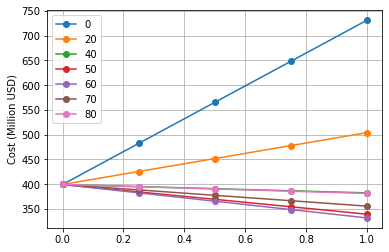

In [56]:
cost = pd.DataFrame(mAbs_cost).mean() + pd.DataFrame(hosp_cost).mean()
(cost.unstack() / 1_000_000).plot(marker='o')
plt.ylabel('Cost (Million USD)')
plt.grid();

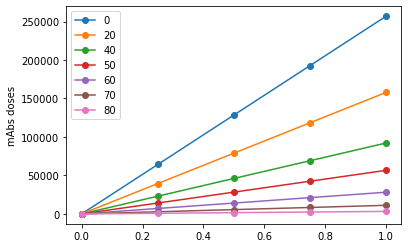

In [57]:
pd.DataFrame(doses).mean().unstack().plot(marker='o')
# plt.semilogy()
plt.ylabel('mAbs doses');

# Burden Averted

In [58]:
#(pd.DataFrame(n_COVID[0,0]).mean().sum() - pd.Series({i: pd.DataFrame(n_COVID[i]).mean().sum() for i in n_COVID}))

In [59]:
#print('averted secondary infections')
def mean_ui(df, c, a, div = 1):
    # shows cases averted with UIs
    z = [(df[0, 0][k] - df[c, a][k]).sum() for k in range(n_draws)]
    return f'{np.mean(z)/div:,.0f} ({np.percentile(z, 2.5)/div:,.0f} - {np.percentile(z, 97.5)/div:,.0f})'
    
mean_ui(n_COVID, .50, 50)

'4,834 (3,375 - 6,257)'

In [60]:
def averted(df, div = 1):
    pretty_table_ui = {}
    pretty_table    = {}
    
    for c in coverage_levels:
        for a in age_lower_bounds:
            pretty_table_ui[c, a] = mean_ui(df, c, a, div)
            pretty_table[c, a] = np.mean([(df[0, 0][k] - df[c, a][k]).sum() for k in range(n_draws)])
    
    return pd.Series(pretty_table), pd.Series(pretty_table_ui)
#averted(n_COVID)

In [61]:
symptomatic_infections_averted = averted(n_COVID)[1]
hospitalizations_averted = averted(n_hosp)[1]
deaths_averted = averted(n_deaths)[1]
doses_averted = averted(doses)[1]

In [62]:
pd.set_option('display.max_rows', 35)

pd.DataFrame({
    'Symptomatic Infections Averted': symptomatic_infections_averted,
    'Hospitalizations Averted': hospitalizations_averted,
    'Deaths Averted': deaths_averted,
    'Doses': doses_averted, #pd.DataFrame(doses).mean()/1e3
    'Incremental Cost':((cost-cost.loc[0,0])/1e6).round(1)
}).unstack().unstack().unstack().loc[:, [0.25, 0.50, 0.75, 1]]

0.25  \
Symptomatic Infections Averted 0       10,958 (7,718 - 13,932)   
                               20        6,735 (4,744 - 8,593)   
                               40        3,932 (2,724 - 5,052)   
                               50        2,417 (1,687 - 3,128)   
                               60          1,203 (843 - 1,536)   
                               70              477 (334 - 643)   
                               80               140 (97 - 191)   
Hospitalizations Averted       0           1,114 (779 - 1,425)   
                               20          1,025 (715 - 1,309)   
                               40            865 (599 - 1,111)   
                               50              702 (487 - 914)   
                               60              479 (330 - 613)   
                               70              248 (172 - 331)   
                               80                91 (63 - 123)   
Deaths Averted                 0                124 (85 - 166)   
                               20               124 (85 - 166)   
                               40               120 (82 - 162)   
                               50               112 (76 - 149)   
                               60                94 (63 - 127)   
                               70                 63 (43 - 84)   
                               80                 32 (20 - 45)   
Doses                          0   -64,208 (-68,185 - -60,069)   
                               20  -39,463 (-42,252 - -36,962)   
                               40  -23,029 (-24,499 - -21,363)   
                               50  -14,155 (-15,165 - -12,981)   
                               60     -7,048 (-7,683 - -6,385)   
                               70     -2,793 (-3,137 - -2,467)   
                               80           -818 (-966 - -682)   
Incremental Cost               0                          82.8   
                               20                         26.2   
                               40                         -4.2   
                               50                        -15.0   
                               60                        -16.9   
                               70                        -10.9   
                               80                         -4.5   

                                                             0.50  \
Symptomatic Infections Averted 0         21,916 (15,435 - 27,863)   
                               20         13,469 (9,488 - 17,186)   
                               40          7,864 (5,447 - 10,104)   
                               50           4,834 (3,375 - 6,257)   
                               60           2,407 (1,686 - 3,072)   
                               70               955 (669 - 1,285)   
                               80                 280 (193 - 382)   
Hospitalizations Averted       0            2,229 (1,557 - 2,850)   
                               20           2,049 (1,430 - 2,617)   
                               40           1,731 (1,197 - 2,221)   
                               50             1,404 (974 - 1,827)   
                               60               957 (660 - 1,227)   
                               70                 495 (343 - 661)   
                               80                 182 (126 - 245)   
Deaths Averted                 0                  248 (170 - 333)   
                               20                 248 (170 - 333)   
                               40                 240 (164 - 323)   
                               50                 223 (152 - 299)   
                               60                 188 (126 - 254)   
                               70                  126 (87 - 169)   
                               80                    63 (40 - 89)   
Doses                          0   -128,416 (-136,369 - -120,138)   
                               20     -78,926 (-84,505 - -73,924)   
                         

In [63]:
ICER = (cost-cost.loc[0,0]) / (averted(n_deaths)[0])
np.round((ICER / 1_000).unstack(), 1)

,0,20,40,50,60,70,80
0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.25,667.7,210.8,-35.3,-134.1,-179.6,-173.8,-142.9
0.50,667.7,210.8,-35.3,-134.1,-179.6,-173.8,-142.9
0.75,667.7,210.8,-35.3,-134.1,-179.6,-173.8,-142.9
1.00,667.7,210.8,-35.3,-134.1,-179.6,-173.8,-142.9


Text(0.5, 0, 'Minimum age for PEP (years)')

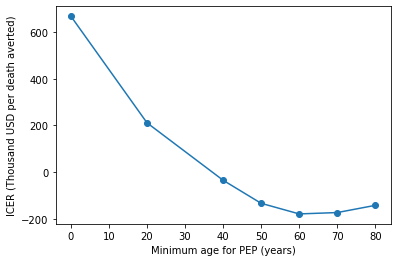

In [64]:
(ICER / 1_000).unstack().T.iloc[:,-1].plot(marker='o')
plt.ylabel('ICER (Thousand USD per death averted)')
plt.xlabel('Minimum age for PEP (years)')
# plt.semilogy();

# PEP with mAbs is a benefit for patients and for hospitals

In [65]:
def summary_results(coverage_level, age_lower_bound):
    n_symp_averted = symptomatic_infections_averted.loc[coverage_level, age_lower_bound]
    n_hosp_averted = hospitalizations_averted.loc[coverage_level, age_lower_bound]
    n_deaths_averted = deaths_averted.loc[coverage_level, age_lower_bound]
    unit_cost = mAbs_unit_cost
    incremental_cost = (cost.loc[coverage_level, age_lower_bound]-cost.loc[0,0])

    result_str = f"""Results: In a month of similar intensity to May, 2021, in USA, a program reaching {coverage_level*100:.0f}% 
    of exposed household members aged {age_lower_bound}+, would avert {n_symp_averted} symptomatic infections,
    {n_hosp_averted} hospitalizations, and {n_deaths_averted} deaths.  If the unit cost of administering the intervention 
    was {pd.Series(unit_cost).mean():,.0f} dollars, this program would save the health system {-incremental_cost:,.0f} dollars."""
    
    print(result_str)

for age in [50, 20, 80]:
    summary_results(1/2, age)

Results: In a month of similar intensity to May, 2021, in USA, a program reaching 50% 
    of exposed household members aged 50+, would avert 4,834 (3,375 - 6,257) symptomatic infections,
    1,404 (974 - 1,827) hospitalizations, and 223 (152 - 299) deaths.  If the unit cost of administering the intervention 
    was 2,554 dollars, this program would save the health system 29,955,003 dollars.
Results: In a month of similar intensity to May, 2021, in USA, a program reaching 50% 
    of exposed household members aged 20+, would avert 13,469 (9,488 - 17,186) symptomatic infections,
    2,049 (1,430 - 2,617) hospitalizations, and 248 (170 - 333) deaths.  If the unit cost of administering the intervention 
    was 2,554 dollars, this program would save the health system -52,308,553 dollars.
Results: In a month of similar intensity to May, 2021, in USA, a program reaching 50% 
    of exposed household members aged 80+, would avert 280 (193 - 382) symptomatic infections,
    182 (126 - 245) h

# Number-plugging values

In [66]:
print(f"""[[summary of data: RCT included X subjects (Y in treatment group and Z in control),
which we combined with confirmed cases data on {len(df_cdc_month):,.0f} individuals and
household structure data derived from {len(acs):,.0f} individuals in {acs.household_id.nunique():,.0f} households.]]
""")

[[summary of data: RCT included X subjects (Y in treatment group and Z in control),
which we combined with confirmed cases data on 154,136 individuals and
household structure data derived from 3,239,553 individuals in 1,428,037 households.]]



In [67]:
n_2 = pd.DataFrame(n_2_unvax)
#n_2

In [68]:
print(f"""[[Confirmed case and household structure results,
summarizing something about the racial segregation of household structure,
the age-assortativity. In [[May]], there were [[{len(df_cdc_month):,.0f}]]
confirmed cases of COVID-19, which we estimate resulted
in {n_2.sum().mean():,.0f} (95% UI {np.percentile(n_2.sum(), 2.5):,.0f}-{np.percentile(n_2.sum(), 97.5):,.0f}) individuals with household exposure to COVID-19. ]] [[stratify counts or rates by race??]]""")

[[Confirmed case and household structure results,
summarizing something about the racial segregation of household structure,
the age-assortativity. In [[May]], there were [[154,136]]
confirmed cases of COVID-19, which we estimate resulted
in 256,832 (95% UI 240,276-272,739) individuals with household exposure to COVID-19. ]] [[stratify counts or rates by race??]]


In [69]:
unvax_race = n_2.unstack().sum().unstack().mean()
unvax_race

Black        43218.623617
Hispanic     50379.567137
Other        27433.120622
White       135800.359725
dtype: float64

In [70]:
unvax_race_per = unvax_race/sum(unvax_race) *100
unvax_race_per

Black       16.827607
Hispanic    19.615792
Other       10.681362
White       52.875239
dtype: float64

In [71]:
#Resut paragraph 1
print(f"""In May, there were {len(df_cdc_month):,.0f} confirmed cases of COVID-19 in the US, which we estimate 
resulted in at least {n_2_total_mean:,.0f} (95% UI {n_2_total_lb:,.0f}-{n_2_total_ub:,.0f}) unvaccinated individuals 
with household exposure to COVID-19. Using the racial and ethnic composition of households, COVID-19 cases, and 
vaccine coverage estimates described above, we estimated unvaccinated household contacts to 
include {unvax_race['Black']:,.0f} ({unvax_race_per['Black']:,.1f}%) non-Hispanic Black individuals, 
{unvax_race['Hispanic']:,.0f} ({unvax_race_per['Hispanic']:,.1f}%) Hispanic individuals, 
{unvax_race['White']:,.0f} ({unvax_race_per['White']:,.1f}%) non-Hispanic white individuals, 
and {unvax_race['Other']:,.0f} ({unvax_race_per['Other']:,.1f}%) members of other non-Hispanic racial and ethnic groups.""")


In May, there were 154,136 confirmed cases of COVID-19 in the US, which we estimate 
resulted in at least 256,832 (95% UI 240,276-272,739) unvaccinated individuals 
with household exposure to COVID-19. Using the racial and ethnic composition of households, COVID-19 cases, and 
vaccine coverage estimates described above, we estimated unvaccinated household contacts to 
include 43,219 (16.8%) non-Hispanic Black individuals, 
50,380 (19.6%) Hispanic individuals, 
135,800 (52.9%) non-Hispanic white individuals, 
and 27,433 (10.7%) members of other non-Hispanic racial and ethnic groups.


In [72]:
print(f"""[[Number who receive PEP in alternative scenarios, and for alternative age cutoffs. Perhaps in a table?  Population-level rates of treatment stratified by race?]]""")

[[Number who receive PEP in alternative scenarios, and for alternative age cutoffs. Perhaps in a table?  Population-level rates of treatment stratified by race?]]


In [73]:
def my_summary(x):
    mean = np.mean(x)
    lb = np.percentile(x, 2.5)
    ub = np.percentile(x, 97.5)
    results = locals()
    results.pop('x')
    for k in results:
        results[k] = '{:,.0f}'.format(results[k])
    results['ui'] = results['lb']+'-'+results['ub']
    results['mean_and_ui'] = f"""{results['mean']} (95% UI {results['ui']})"""
    return results

total_PEP = {}
for c,a in n_PEP.keys():
    total_PEP[c,a] = my_summary(pd.DataFrame(n_PEP[c,a]).sum())

In [74]:
print(f"""In a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
we estimate {total_PEP[.5,50]['mean_and_ui']} individuals would be treated.""")

In a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
we estimate 28,309 (95% UI 25,961-30,330) individuals would be treated.


In [75]:
#results paragraph 2
print(f"""A scenario providing PEP to 50% of unvaccinated household contacts age 50+ resulted in treatment of {total_PEP[.5,50]['mean_and_ui']} individuals, with fewer individuals treated at higher age thresholds (Table 1). PEP coverage of 50% of unvaccinated contacts age 50+ averted {symptomatic_infections_averted.loc[0.5, 50]} symptomatic COVID-19 cases, {hospitalizations_averted.loc[0.5, 50]} hospitalizations, and prevented {deaths_averted.loc[0.5, 50]} deaths. Expanding the age threshold to 20+ years increased the averted burden to {symptomatic_infections_averted.loc[0.5, 20]} symptomatic COVID-19 cases, {hospitalizations_averted.loc[0.5, 20]} hospitalizations, and {deaths_averted.loc[0.5, 20]} deaths, while shrinking the age threshold to age 80+ years reduced the burden averted to {symptomatic_infections_averted.loc[0.5, 80]} symptomatic COVID-19 cases, {hospitalizations_averted.loc[0.5, 80]} hospitalizations, and {deaths_averted.loc[0.5, 80]} deaths for the same assumption of 50% coverage of unvaccinated contacts in each target age group. Expanding PEP coverage by half from 50% to 75% resulted in corresponding 50% reductions in symptomatic COVID-19 cases, hospitalizations, and deaths.""")

A scenario providing PEP to 50% of unvaccinated household contacts age 50+ resulted in treatment of 28,309 (95% UI 25,961-30,330) individuals, with fewer individuals treated at higher age thresholds (Table 1). PEP coverage of 50% of unvaccinated contacts age 50+ averted 4,834 (3,375 - 6,257) symptomatic COVID-19 cases, 1,404 (974 - 1,827) hospitalizations, and prevented 223 (152 - 299) deaths. Expanding the age threshold to 20+ years increased the averted burden to 13,469 (9,488 - 17,186) symptomatic COVID-19 cases, 2,049 (1,430 - 2,617) hospitalizations, and 248 (170 - 333) deaths, while shrinking the age threshold to age 80+ years reduced the burden averted to 280 (193 - 382) symptomatic COVID-19 cases, 182 (126 - 245) hospitalizations, and 63 (40 - 89) deaths for the same assumption of 50% coverage of unvaccinated contacts in each target age group. Expanding PEP coverage by half from 50% to 75% resulted in corresponding 50% reductions in symptomatic COVID-19 cases, hospitalizations,

In [76]:
#result paragraph 3
print(f"""The rates of averted COVID-19 cases, hospitalization, and death differed by race and ethnicity. Assuming 50% mAbs PEP coverage of unvaccinated individuals age 50+, the estimated rate of averted secondary infections was {averted_symptomatic_race[0]}, {averted_symptomatic_race[1]}, {averted_symptomatic_race[3]}, and {averted_symptomatic_race[2]} symptomatic infections per 10,000,000 person-months among non-Hispanic Black, Hispanic, non-Hispanic white, and non-Hispanic members of other racial and ethnic groups, respectively.  The averted hospitalization rate per 10,000,000 person-months were {averted_hosp_race[0]}, {averted_hosp_race[1]}, {averted_hosp_race[3]}, and {averted_hosp_race[2]} while the averted death rates per 10,000,000 person-months were {averted_death_race[0]}, {averted_death_race[1]}, {averted_death_race[3]}, and {averted_death_race[2]} for the same races, respectively.""") 

The rates of averted COVID-19 cases, hospitalization, and death differed by race and ethnicity. Assuming 50% mAbs PEP coverage of unvaccinated individuals age 50+, the estimated rate of averted secondary infections was 212, 118, 147, and 164 symptomatic infections per 10,000,000 person-months among non-Hispanic Black, Hispanic, non-Hispanic white, and non-Hispanic members of other racial and ethnic groups, respectively.  The averted hospitalization rate per 10,000,000 person-months were 85, 39, 35, and 57 while the averted death rates per 10,000,000 person-months were 132, 81, 44, and 131 for the same races, respectively.


In [77]:
print(f"""While in a hypothetical scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate {total_PEP[.5,80]['mean']} (95% UI {total_PEP[.5,80]['ui']}) individuals would be treated,""")

While in a hypothetical scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate 1,635 (95% UI 1,365-1,932) individuals would be treated,


In [78]:
print(f"""and in a hypothetical scenario where 50% of those exposed and of age 20 or older receive PEP,
we estimate {total_PEP[.5,20]['mean']} (95% UI {total_PEP[.5,20]['ui']}) individuals would be treated.""")

and in a hypothetical scenario where 50% of those exposed and of age 20 or older receive PEP,
we estimate 78,926 (95% UI 73,924-84,505) individuals would be treated.


In [79]:
total_COVID = {}
for c,a in n_COVID.keys():
    total_COVID[c,a] = my_summary(pd.DataFrame(n_COVID[c,a]).sum())

In [80]:
print(f"""[[Number who develop symptomatic COVID-19 in baseline and alternative scenarios, and for alternative age cutoffs. Including stratification by race and ethnicity.]]""")

print(f"""We estimate that without PEP, {total_COVID[0,0]['mean_and_ui']} individuals developed a symptomatic COVID-19 infection from a household exposure,
      while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
{total_COVID[.5,50]['mean_and_ui']} individuals developed a symptomatic infection.""")

[[Number who develop symptomatic COVID-19 in baseline and alternative scenarios, and for alternative age cutoffs. Including stratification by race and ethnicity.]]
We estimate that without PEP, 53,847 (95% UI 42,885-64,259) individuals developed a symptomatic COVID-19 infection from a household exposure,
      while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
49,013 (95% UI 39,885-58,779) individuals developed a symptomatic infection.


In [81]:
print(f"""In a hypothetical scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate {total_COVID[.5,80]['mean_and_ui']} individuals developed symptomatic infection,
and in a hypothetical scenario where 50% of those exposed and of age 20 or older receive PEP,
we estimate {total_COVID[.5,20]['mean_and_ui']} individuals developed symptomatic infection.""")

In a hypothetical scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate 53,567 (95% UI 42,712-63,941) individuals developed symptomatic infection,
and in a hypothetical scenario where 50% of those exposed and of age 20 or older receive PEP,
we estimate 40,377 (95% UI 33,090-48,944) individuals developed symptomatic infection.


In [82]:
total_hosp = {}
for c,a in n_hosp.keys():
    total_hosp[c,a] = my_summary(pd.DataFrame(n_hosp[c,a]).sum())
total_deaths = {}
for c,a in n_deaths.keys():
    total_deaths[c,a] = my_summary(pd.DataFrame(n_deaths[c,a]).sum())

In [83]:
print(f"""We estimate that without PEP, {total_hosp[0,0]['mean_and_ui']} individuals would be hospitalized
because of a COVID-19 infection from a household exposure,
while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
{total_hosp[.5,50]['mean_and_ui']} individuals would be hospitalized;
in a scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate {total_hosp[.5,80]['mean_and_ui']} individuals would be hospitalized,
and in a scenario where 50% of those exposed and of age 20 or older receive PEP,
{total_hosp[.5,20]['mean_and_ui']} individuals would be hospitalized.
""")

We estimate that without PEP, 5,475 (95% UI 4,336-6,551) individuals would be hospitalized
because of a COVID-19 infection from a household exposure,
while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
4,071 (95% UI 3,328-4,944) individuals would be hospitalized;
in a scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate 5,293 (95% UI 4,222-6,341) individuals would be hospitalized,
and in a scenario where 50% of those exposed and of age 20 or older receive PEP,
3,425 (95% UI 2,800-4,178) individuals would be hospitalized.



In [84]:
print(f"""We estimate that without PEP, {total_deaths[0,0]['mean_and_ui']} individuals would die
because of a COVID-19 infection from a household exposure,
while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
{total_deaths[.5,50]['mean_and_ui']} individuals would die;
in a scenario where 50% of those exposed and of age 80 or older receive PEP,
{total_deaths[.5,80]['mean_and_ui']} individuals would die,
and in a scenario where 50% of those exposed and of age 20 or older receive PEP,
{total_deaths[.5,20]['mean_and_ui']} individuals would die.
""")

We estimate that without PEP, 609 (95% UI 468-763) individuals would die
because of a COVID-19 infection from a household exposure,
while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
386 (95% UI 304-480) individuals would die;
in a scenario where 50% of those exposed and of age 80 or older receive PEP,
546 (95% UI 424-672) individuals would die,
and in a scenario where 50% of those exposed and of age 20 or older receive PEP,
361 (95% UI 283-452) individuals would die.



In [85]:
total_cost = {}
hosp_cost_str = {}
PEP_cost = {}
savings = {}
incremental_cost = {}

total_cost_0 = (pd.Series(mAbs_cost[0,0]) + pd.Series(hosp_cost[0,0])) / 1_000_000

for c,a in n_hosp.keys():
    total_cost_ca = (pd.Series(mAbs_cost[c,a]) + pd.Series(hosp_cost[c,a])) / 1_000_000
    total_cost[c,a] = my_summary(total_cost_ca)
    savings[c,a] = my_summary(total_cost_0 - total_cost_ca)
    incremental_cost[c,a] = my_summary(total_cost_ca - total_cost_0)
    hosp_cost_str[c,a] = my_summary(pd.Series(hosp_cost[c,a])/1_000_000)
    PEP_cost[c,a] = my_summary(pd.Series(mAbs_cost[c,a])/1_000_000)

hosp_cost_str[.5,20] , PEP_cost[.5,20]

({'mean': '250',
  'lb': '184',
  'ub': '318',
  'ui': '184-318',
  'mean_and_ui': '250 (95% UI 184-318)'},
 {'mean': '202',
  'lb': '175',
  'ub': '222',
  'ui': '175-222',
  'mean_and_ui': '202 (95% UI 175-222)'})

In [86]:
savings[0.5,50]

{'mean': '30',
 'lb': '-6',
 'ub': '60',
 'ui': '-6-60',
 'mean_and_ui': '30 (95% UI -6-60)'}

In [87]:
#results paragraph 3
print(f"""We estimate that without PEP, the cost of hospitalizations due to COVID-19 infections from household exposure 
would be {hosp_cost_str[0,0]['mean_and_ui']} million dollars, while in a hypothetical scenario where 50% of
unvaccinated household contacts age 50 or older receive PEP, the cost of hospitalizations would 
be {hosp_cost_str[.5,50]['mean_and_ui']} million dollars and the cost of PEP would be {PEP_cost[.5,50]['mean_and_ui']} 
million dollars, for a total of {total_cost[.5,50]['mean_and_ui']} million dollars, which is a savings 
of {savings[.5,50]['mean_and_ui']} million dollars compared to the without-PEP scenario. In a scenario 
where 50% of those exposed and of age 80 or older receive PEP, the cost of hospitalizations would
be {hosp_cost_str[.5,80]['mean_and_ui']} million dollars and the cost of PEP would be {PEP_cost[.5,80]['mean_and_ui']} 
million dollars, for a total of {total_cost[.5,80]['mean_and_ui']} million dollars, which is a savings 
of {savings[.5,80]['mean_and_ui']} million dollars compared to the without-PEP scenario. Alternatively, 
in a scenario where 50% of those exposed and of age 20 or older receive PEP, the cost of hospitalizations 
would be {hosp_cost_str[.5,20]['mean_and_ui']} million dollars and the cost of PEP would 
be {PEP_cost[.5,20]['mean_and_ui']} million dollars, for a total of {total_cost[.5,20]['mean_and_ui']} million 
dollars, which is a total of {incremental_cost[.5,20]['mean_and_ui']} million dollars more than in the without-PEP 
scenario. The incremental cost and COVID-19 deaths averted for a range of scenarios is summarized in Figure 2.""")

We estimate that without PEP, the cost of hospitalizations due to COVID-19 infections from household exposure 
would be 400 (95% UI 312-508) million dollars, while in a hypothetical scenario where 50% of
unvaccinated household contacts age 50 or older receive PEP, the cost of hospitalizations would 
be 297 (95% UI 223-378) million dollars and the cost of PEP would be 72 (95% UI 61-80) 
million dollars, for a total of 370 (95% UI 295-452) million dollars, which is a savings 
of 30 (95% UI -6-60) million dollars compared to the without-PEP scenario. In a scenario 
where 50% of those exposed and of age 80 or older receive PEP, the cost of hospitalizations would
be 386 (95% UI 300-492) million dollars and the cost of PEP would be 4 (95% UI 3-5) 
million dollars, for a total of 390 (95% UI 305-496) million dollars, which is a savings 
of 9 (95% UI 5-13) million dollars compared to the without-PEP scenario. Alternatively, 
in a scenario where 50% of those exposed and of age 20 or older recei

In [88]:
total_cost[c,a]

{'mean': '381',
 'lb': '297',
 'ub': '485',
 'ui': '297-485',
 'mean_and_ui': '381 (95% UI 297-485)'}

In [89]:
import seaborn as sns

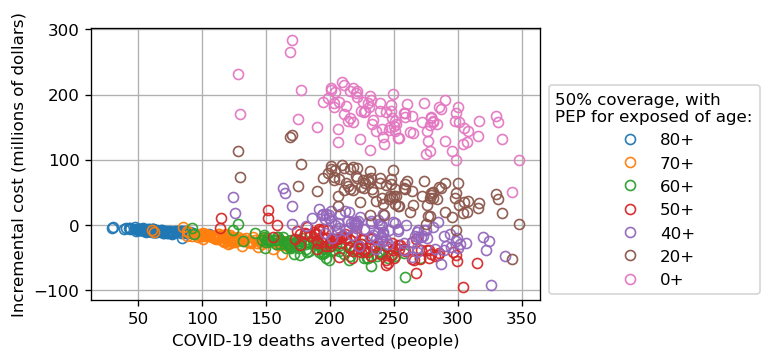

In [90]:
plt.figure(figsize=(6.5,3), dpi=120)
df_plot = []
for c in [0.25, .5, .75]:
    for i, a in enumerate(age_lower_bounds[::-1]):
        s_cost = (pd.Series(mAbs_cost[c,a]) + pd.Series(hosp_cost[c,a])) / 1e6
        s_cost -= (pd.Series(mAbs_cost[0,0]) + pd.Series(hosp_cost[0,0])) / 1e6
        
        s_deaths = pd.DataFrame(n_deaths[c,a]).sum(axis=0)
        s_deaths -= pd.DataFrame(n_deaths[0,0]).sum(axis=0)
        s_deaths *= -1
        
        if c == 0.5:
            df_plot.append({
            'Age': a,
            'Cost': s_cost,
            'Deaths': s_deaths
            })
            
            plt.plot(s_deaths, s_cost, 'o', label=f'{a}+', alpha=.95, color='none', mec=f'C{i}', mew=1)
#         else:
#             plt.plot(s_deaths, s_cost, 'o', color='grey')
plt.legend(loc=(1.02, .02), title='50% coverage, with\nPEP for exposed of age:')
plt.xlabel('COVID-19 deaths averted (people)')
plt.ylabel('Incremental cost (millions of dollars)')
plt.grid()
plt.subplots_adjust(right=.7);
plt.savefig('output_scenario2.svg', dpi=300, bbox_inches='tight')


In [91]:
def incost(coverage_level, age_lower_bound):
    n_deaths_averted = deaths_averted.loc[coverage_level, age_lower_bound]
    incremental_cost = (cost.loc[coverage_level, age_lower_bound]-cost.loc[0,0])

    result_str = f"""{age_lower_bound}+: Deaths = {n_deaths_averted}, Incremental cost = ${-incremental_cost:,.0f}."""
    
    print(result_str)
    
for i in age_lower_bounds:
    incost(1/2, i)

0+: Deaths = 248 (170 - 333), Incremental cost = $-165,674,012.
20+: Deaths = 248 (170 - 333), Incremental cost = $-52,308,553.
40+: Deaths = 240 (164 - 323), Incremental cost = $8,455,959.
50+: Deaths = 223 (152 - 299), Incremental cost = $29,955,003.
60+: Deaths = 188 (126 - 254), Incremental cost = $33,717,358.
70+: Deaths = 126 (87 - 169), Incremental cost = $21,821,354.
80+: Deaths = 63 (40 - 89), Incremental cost = $9,062,457.


In [110]:
#Table 1
#nvaccinated household contacts n_2.sum().mean(), (np.percentile(n_2.sum(), 2.5),np.percentile(n_2.sum(), 97.5))
def m_ui(z):
    return f'{np.mean(z):,.0f} ({np.percentile(z, 2.5):,.0f} - {np.percentile(z, 97.5):,.0f})'

def contacts(df,age_range):
    results = m_ui(pd.DataFrame(df).unstack(0).sum().unstack(0).loc[age_range:].sum())
    return results


tab1 = {'Age threshold for PEP': ['Baseline (no PEP)', '80+', '50+', '20+'],
        'Secondary Attack Rate': '21.1%',
        'Household contacts': [contacts(n_2_all,0), contacts(n_2_all,80), contacts(n_2_all,50), contacts(n_2_all,20)],
        'Unvaccinated household contacts': [contacts(n_2_unvax,0), contacts(n_2_unvax,80), contacts(n_2_unvax,50), contacts(n_2_unvax,20)],
        'PEP coverage': ['0', '50%', '50%', '50%'],
        'Number Treated with PEP': ['0', total_PEP[.5, 80]['mean_and_ui'], total_PEP[.5,50]['mean_and_ui'], total_PEP[.5,20]['mean_and_ui']],
        'Symptomatic COVID-19 from household exposure': [total_COVID[0, 0]['mean_and_ui'], total_COVID[.5,80]['mean_and_ui'] , total_COVID[.5,50]['mean_and_ui'], total_COVID[.5,20]['mean_and_ui']],
        'Hospitalizations from household exposure': [total_hosp[0, 0]['mean_and_ui'], total_hosp[.5, 80]['mean_and_ui'] , total_hosp[.5,50]['mean_and_ui'], total_hosp[.5,20]['mean_and_ui']],
        'Deaths from household exposure': [total_deaths[0, 0]['mean_and_ui'], total_deaths[.5, 80]['mean_and_ui'], total_deaths[.5,50]['mean_and_ui'], total_deaths[.5,20]['mean_and_ui']]}


pd.DataFrame(tab1, columns = ['Secondary Attack Rate', 
                              'Household contacts',
                              'Unvaccinated household contacts',
                              'PEP coverage',
                              'Number Treated with PEP',
                              'Symptomatic COVID-19 from household exposure', 
                              'Hospitalizations from household exposure', 
                              'Deaths from household exposure'], 
            index = ['Baseline (no PEP)', '80+', '50+', '20+']).replace('95% UI ','', regex=True)

,Secondary Attack Rate,Household contacts,Unvaccinated household contacts,PEP coverage,Number Treated with PEP,Symptomatic COVID-19 from household exposure,Hospitalizations from household exposure,Deaths from household exposure
Baseline (no PEP),21.1%,"381,357 (374,041 - 389,817)","256,832 (240,276 - 272,739)",0,0,"53,847 (42,885-64,259)","5,475 (4,336-6,551)",609 (468-763)
80+,21.1%,"4,855 (4,181 - 5,706)","3,271 (2,730 - 3,864)",50%,"1,635 (1,365-1,932)","53,567 (42,712-63,941)","5,293 (4,222-6,341)",546 (424-672)
50+,21.1%,"84,063 (80,884 - 88,099)","56,618 (51,923 - 60,660)",50%,"28,309 (25,961-30,330)","49,013 (39,885-58,779)","4,071 (3,328-4,944)",386 (304-480)
20+,21.1%,"234,381 (229,181 - 239,410)","157,853 (147,849 - 169,009)",50%,"78,926 (73,924-84,505)","40,377 (33,090-48,944)","3,425 (2,800-4,178)",361 (283-452)


In [93]:
attack_rate_without_mAbs.mean(), attack_rate_with_mAbs.mean()

(0.2097430406852249, 0.0389980516266805)

In [94]:
pep = {}
covid = {}
hosp = {}
death = {}
incremental = {}
for c,a in n_COVID.keys():
    pep[c,a] = my_summary(pd.DataFrame(n_PEP[c,a]).sum())['mean_and_ui']
    covid[c,a] = my_summary(pd.DataFrame(n_COVID[c,a]).sum())['mean_and_ui']
    hosp[c,a] = my_summary(pd.DataFrame(n_hosp[c,a]).sum())['mean_and_ui']
    death[c,a] = my_summary(pd.DataFrame(n_deaths[c,a]).sum())['mean_and_ui']

In [95]:
res = pd.DataFrame({
    'Number Treated with PEP': pep,
    'Symptomatic COVID-19 from household exposure': covid,
    'Hospitalizations from household exposure' : hosp,
    'Deaths from household exposure': death
}).unstack().unstack().unstack().replace('95% UI ','', regex=True)

#.rename(columns = {'0.00':'Baseline'})
#.drop([0], axis=1)
res.rename(columns = {res.columns[0]:'Baseline'})

Baseline  \
Number Treated with PEP                      0                  0 (0-0)   
                                             20                 0 (0-0)   
                                             40                 0 (0-0)   
                                             50                 0 (0-0)   
                                             60                 0 (0-0)   
                                             70                 0 (0-0)   
                                             80                 0 (0-0)   
Symptomatic COVID-19 from household exposure 0   53,847 (42,885-64,259)   
                                             20  53,847 (42,885-64,259)   
                                             40  53,847 (42,885-64,259)   
                                             50  53,847 (42,885-64,259)   
                                             60  53,847 (42,885-64,259)   
                                             70  53,847 (42,885-64,259)   
                                             80  53,847 (42,885-64,259)   
Hospitalizations from household exposure     0      5,475 (4,336-6,551)   
                                             20     5,475 (4,336-6,551)   
                                             40     5,475 (4,336-6,551)   
                                             50     5,475 (4,336-6,551)   
                                             60     5,475 (4,336-6,551)   
                                             70     5,475 (4,336-6,551)   
                                             80     5,475 (4,336-6,551)   
Deaths from household exposure               0            609 (468-763)   
                                             20           609 (468-763)   
                                             40           609 (468-763)   
                                             50           609 (468-763)   
                                             60           609 (468-763)   
                                             70           609 (468-763)   
                                             80           609 (468-763)   

                                                                   0.25  \
Number Treated with PEP                      0   64,208 (60,069-68,185)   
                                             20  39,463 (36,962-42,252)   
                                             40  23,029 (21,363-24,499)   
                                             50  14,155 (12,981-15,165)   
                                             60     7,048 (6,385-7,683)   
                                             70     2,793 (2,467-3,137)   
                                             80           818 (682-966)   
Symptomatic COVID-19 from household exposure 0   42,889 (35,175-51,613)   
                                             20  47,112 (38,610-56,482)   
                                             40  49,915 (40,369-59,755)   
                                             50  51,430 (41,329-61,519)   
                                             60  52,643 (42,107-62,862)   
                                             70  53,369 (42,579-63,696)   
                                             80  53,707 (42,799-64,100)   
Hospitalizations from household exposure     0      4,360 (3,581-5,261)   
                                             20     4,450 (3,654-5,367)   
                                             40     4,609 (3,777-5,558)   
                                             50     4,773 (3,885-5,747)   
                                             60     4,996 (4,013-5,989)   
                                             70     5,227 (4,170-6,258)   
                                             80     5,384 (4,279-6,446)   
Deaths from household exposure               0            485 (383-604)   
                                             20           485 (383-604)   
                                             40           490 (385-609)   
            

## Costs Table:

In [96]:
total_cost_mui = {}
hosp_cost_str_mui = {}
PEP_cost_mui = {}
savings_mui = {}
incremental_cost_mui = {}

total_cost_0 = (pd.Series(mAbs_cost[0,0]) + pd.Series(hosp_cost[0,0])) / 1_000_000

for c,a in n_hosp.keys():
    total_cost_ca = (pd.Series(mAbs_cost[c,a]) + pd.Series(hosp_cost[c,a])) / 1_000_000
    total_cost_mui[c,a] = my_summary(total_cost_ca)['mean_and_ui']
    savings_mui[c,a] = my_summary(total_cost_0 - total_cost_ca)['mean_and_ui']
    incremental_cost_mui[c,a] = my_summary(total_cost_ca - total_cost_0)['mean_and_ui']
    hosp_cost_str_mui[c,a] = my_summary(pd.Series(hosp_cost[c,a])/1_000_000)['mean_and_ui']
    PEP_cost_mui[c,a] = my_summary(pd.Series(mAbs_cost[c,a])/1_000_000)['mean_and_ui']

res_costs = pd.DataFrame({
    'Total Cost': total_cost_mui,
    'Hospital Cost': hosp_cost_str_mui,
    'PEP Cost' : PEP_cost_mui,
    'Savings': savings_mui,
    'Incremental Cost': incremental_cost_mui
    #,'Incremental Cost prob': incremental_cost_prob
    
}).unstack().unstack().unstack().replace('95% UI ','', regex=True)

res_costs.rename(columns = {res_costs.columns[0]:'Baseline'})

Baseline            0.25               0.5  \
Total Cost       0   400 (312-508)   482 (402-575)     565 (491-642)   
                 20  400 (312-508)   426 (348-517)     452 (381-524)   
                 40  400 (312-508)   395 (317-489)     391 (320-469)   
                 50  400 (312-508)   385 (305-480)     370 (295-452)   
                 60  400 (312-508)   383 (300-482)     366 (288-456)   
                 70  400 (312-508)   389 (304-492)     378 (295-476)   
                 80  400 (312-508)   395 (308-502)     390 (305-496)   
Hospital Cost    0   400 (312-508)   318 (242-405)     237 (174-302)   
                 20  400 (312-508)   325 (247-413)     250 (184-318)   
                 40  400 (312-508)   336 (257-428)     273 (202-347)   
                 50  400 (312-508)   348 (268-443)     297 (223-378)   
                 60  400 (312-508)   365 (281-463)     330 (250-419)   
                 70  400 (312-508)   382 (296-484)     363 (280-461)   
                 80  400 (312-508)   393 (306-500)     386 (300-492)   
PEP Cost         0         0 (0-0)   164 (143-180)     328 (286-359)   
                 20        0 (0-0)    101 (87-111)     202 (175-222)   
                 40        0 (0-0)      59 (50-65)     118 (101-130)   
                 50        0 (0-0)      36 (31-40)        72 (61-80)   
                 60        0 (0-0)      18 (16-20)        36 (31-40)   
                 70        0 (0-0)         7 (6-8)        14 (12-16)   
                 80        0 (0-0)         2 (2-3)           4 (3-5)   
Savings          0         0 (0-0)  -83 (-113--52)  -166 (-226--104)   
                 20        0 (0-0)    -26 (-52--1)     -52 (-104--1)   
                 40        0 (0-0)      4 (-18-24)        8 (-36-48)   
                 50        0 (0-0)      15 (-3-30)        30 (-6-60)   
                 60        0 (0-0)       17 (5-27)        34 (10-54)   
                 70        0 (0-0)       11 (5-17)        22 (10-33)   
                 80        0 (0-0)         5 (2-7)          9 (5-13)   
Incremental Cost 0         0 (0-0)     83 (52-113)     166 (104-226)   
                 20        0 (0-0)       26 (1-52)        52 (1-104)   
                 40        0 (0-0)     -4 (-24-18)       -8 (-48-36)   
                 50        0 (0-0)     -15 (-30-3)       -30 (-60-6)   
                 60        0 (0-0)    -17 (-27--5)     -34 (-54--10)   
                 70        0 (0-0)    -11 (-17--5)     -22 (-33--10)   
                 80        0 (0-0)      -5 (-7--2)       -9 (-13--5)   

                                 0.75               1.0  
Total Cost       0      648 (571-727)     731 (642-826)  
                 20     478 (413-544)     504 (440-584)  
                 40     387 (322-450)     383 (324-444)  
                 50     355 (288-422)     340 (278-400)  
                 60     349 (274-430)     332 (267-403)  
                 70     367 (286-460)     356 (277-445)  
                 80     386 (301-490)     381 (297-485)  
Hospital Cost    0      156 (107-207)       75 (31-142)  
                 20     176 (122-229)      101 (56-162)  
                 40     210 (152-270)     147 (101-200)  
                 50     246 (183-315)     195 (141-250)  
                 60     295 (218-374)     260 (191-329)  
                 70     345 (264-438)     327 (248-416)  
                 80     380 (294-484)     373 (288-477)  
PEP Cost         0      492 (429-539)     656 (572-718)  
                 20     302 (262-334)     403 (350-445)  
                 40     176 (151-196)     235 (201-261)  
                 50      108 (92-120)     145 (123-160)  
                 60        54 (47-60)        72 (63-80)  
                 70        21 (18-25)        29 (24-33)  
                 80           6 (5-8)          8 (7-10)  
Savings          0   -249 (-339--156)  -331 (-452--208)  
                 20     -78 (-156--2)    -105 (-208--3)  
                 40       13 (-54-72)    

In [108]:
tab2 = {'Age threshold for PEP': ['Baseline (no PEP)', '80+', '80+', '80+',
                                  '50+', '50+', '50+',
                                  '20+', '20+', '20+'],
        'PEP coverage': ['0', '50%', '75%', '100%', 
                         '50%', '75%', '100%', 
                         '50%', '75%', '100%'],
        'PEP costs': ['0', PEP_cost_mui[0.5,80], PEP_cost_mui[0.75, 80], PEP_cost_mui[1,80],
                     PEP_cost_mui[0.5,50], PEP_cost_mui[0.75, 50], PEP_cost_mui[1,50],
                     PEP_cost_mui[0.5,20], PEP_cost_mui[0.75, 20], PEP_cost_mui[1,20]],
        'Secondary Attack Rate': '21.1%',
        'Hospitalization costs': ['0', hosp_cost_str_mui[0.5,80], hosp_cost_str_mui[0.75, 80], hosp_cost_str_mui[1,80],
                                  hosp_cost_str_mui[0.5,50], hosp_cost_str_mui[0.75, 50], hosp_cost_str_mui[1,50],
                                  hosp_cost_str_mui[0.5,20], hosp_cost_str_mui[0.75, 20], hosp_cost_str_mui[1,20]],
        'Total costs': ['0', total_cost_mui[0.5,80], total_cost_mui[0.75, 80], total_cost_mui[1,80],
                        total_cost_mui[0.5,50], total_cost_mui[0.75, 50], total_cost_mui[1,50],
                        total_cost_mui[0.5,20], total_cost_mui[0.75, 20], total_cost_mui[1,20]],
        'Incremental costs': ['0', incremental_cost_mui[0.5,80], incremental_cost_mui[0.75, 80], incremental_cost_mui[1,80],
                        incremental_cost_mui[0.5,50], incremental_cost_mui[0.75, 50], incremental_cost_mui[1,50],
                        incremental_cost_mui[0.5,20], incremental_cost_mui[0.75, 20], incremental_cost_mui[1,20]]}
        
pd.DataFrame(tab2, columns = ['PEP coverage',
                              'PEP costs',
                              'Secondary Attack Rate', 
                              'Hospitalization costs', 
                              'Total costs', 
                              'Incremental costs'], 
            index = ['Baseline (no PEP)', '80+', '80+', '80+',
                                  '50+', '50+', '50+',
                                  '20+', '20+', '20+']).replace('95% UI ','', regex=True)

,PEP coverage,PEP costs,Secondary Attack Rate,Hospitalization costs,Total costs,Incremental costs
Baseline (no PEP),0,0,21.1%,0,0,0
80+,50%,4 (3-5),21.1%,386 (300-492),390 (305-496),-9 (-13--5)
80+,75%,6 (5-8),21.1%,380 (294-484),386 (301-490),-14 (-20--7)
80+,100%,8 (7-10),21.1%,373 (288-477),381 (297-485),-18 (-26--9)
50+,50%,72 (61-80),21.1%,297 (223-378),370 (295-452),-30 (-60-6)
50+,75%,108 (92-120),21.1%,246 (183-315),355 (288-422),-45 (-90-9)
50+,100%,145 (123-160),21.1%,195 (141-250),340 (278-400),-60 (-120-11)
20+,50%,202 (175-222),21.1%,250 (184-318),452 (381-524),52 (1-104)
20+,75%,302 (262-334),21.1%,176 (122-229),478 (413-544),78 (2-156)
20+,100%,403 (350-445),21.1%,101 (56-162),504 (440-584),105 (3-208)


## Probabilities

In [97]:
def prob_neg(x):
    count = np.sum(x < 0)
    total = len(x)
    prob = count/total
    results = locals()
    results.pop('x')
    for k in results:
        results[k] = '{:,.2f}'.format(results[k])
    results['prob'] = f"""{results['prob']}"""
    return results


In [101]:
incremental_cost_prob = {}
ct = pd.DataFrame(mAbs_cost) + pd.DataFrame(hosp_cost)

for c,a in n_hosp.keys():
    incremental_cost_prob[c,a] = prob_neg(ct[c,a]-ct[0,0])['prob']

In [102]:
prob_saving = pd.DataFrame({
    'Probabilities': incremental_cost_prob,
}).unstack().unstack().unstack().replace('95% UI ','', regex=True)

prob_saving.rename(columns = {prob_saving.columns[0]:'Baseline'})

Baseline  0.25   0.5  0.75   1.0
Probabilities 0      0.00  0.00  0.00  0.00  0.00
              20     0.00  0.02  0.02  0.02  0.02
              40     0.00  0.63  0.63  0.63  0.63
              50     0.00  0.96  0.96  0.96  0.96
              60     0.00  0.99  0.99  0.99  0.99
              70     0.00  1.00  1.00  1.00  1.00
              80     0.00  1.00  1.00  1.00  1.00